In [1]:
import numpy as np

def criaDatasetBidimensionalBinárioInclinado(n=20, slop=[2, 1], intercept=0.4):
    """
    Cria um dataset bidimensional binário com
    inclinação e interceptação do eixo vertical
    parametrizados.
    """
    X = np.random.uniform(size=(n,2))*5
    AUX = np.multiply(X, slop)-[0, intercept]
    y = np.array(AUX[:,0]>AUX[:,1], dtype=int)*2-1
    return X, y

slop = [2, 1]
intercept = -0.4
Xtr, ytr = criaDatasetBidimensionalBinárioInclinado(n=20, slop=slop, intercept=intercept)
Xtr, ytr

(array([[0.8248532 , 2.53629361],
        [0.67006297, 2.77495461],
        [2.05322899, 0.16840992],
        [3.11719494, 1.68218526],
        [1.80771168, 1.52508785],
        [4.98927313, 4.83777041],
        [0.59165251, 2.39092478],
        [3.67724738, 3.25336656],
        [0.25398121, 1.91950608],
        [1.58199415, 0.92387748],
        [4.01063893, 2.8288542 ],
        [2.12841686, 1.8838005 ],
        [3.7713591 , 3.5601747 ],
        [3.4879439 , 0.82627138],
        [4.9235977 , 3.17012163],
        [4.73756694, 4.77366636],
        [4.82334087, 4.38194863],
        [1.43238193, 0.16615119],
        [2.09987583, 1.06771082],
        [0.64832599, 4.95921729]]),
 array([-1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, -1]))

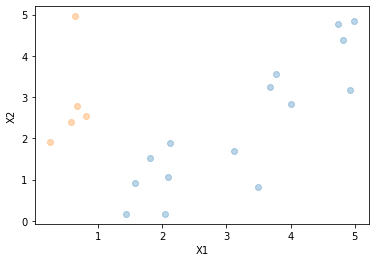

In [2]:
import matplotlib.pyplot as plt

def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotaDatasetBidimensional(Xtr, ytr)

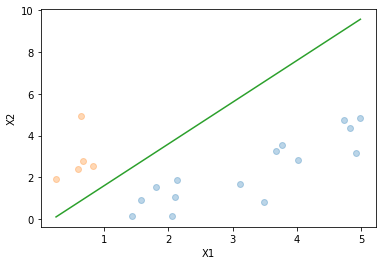

In [3]:
def plotaHiperplanoDatasetBidimensional(X, y, vetor, intercept=0):
    """
    Plota um dataset bidimensional com um hiperplano definido por um
    vetor e o valor em que este vetor intercepta o eixo vertical.
    """
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    xs = np.linspace(x0min, x0max, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - intercept / vetor[1]
    plotaDatasetBidimensional(X, y)
    plt.plot(xs,ys)

vetor_hyperplano = np.array(slop) * np.array([1, -1])
plotaHiperplanoDatasetBidimensional(Xtr, ytr, vetor_hyperplano, intercept)

In [4]:
def sign(a):
    return (a >= 0) * 2 - 1

In [5]:
def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [6]:
from abc import ABC, abstractstaticmethod

class Custo(ABC):
    @abstractstaticmethod
    def custo(y, ypred):
        pass
    @abstractstaticmethod
    def gradiente(y, ypred, X):
        pass

class WidrowHoff(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - (y * ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - ypred)

class SmoothedSurrogate(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - sign(ypred))

class HingeLoss(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        errosmarginais = (y * ypred) < 1
        ymarginais = np.copy(y)
        ymarginais[~errosmarginais] = 0
        g = X.T @ ymarginais
        return g

from scipy.special import expit

class LogLikelihood(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.log(1 + np.exp(- y * ypred)))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - (expit(ypred)*2-1))

In [7]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
    @abstractmethod
    def getW(self, X, y, activation):
        pass

class DescidaGradiente(TrainingAlgorithm):
    def __init__(self, max_iter=1000, learning_rate=0.005, 
                       regularization=0, cost=WidrowHoff()):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.cost = cost

    def getW(self, X, y):
        w = np.random.uniform(-1, 1, size=X.shape[1])
        for _ in range(self.max_iter):
            ypred = X @ w
            if self.cost.custo(y, ypred) == 0:
                break
            w *= 1 - self.regularization * self.learning_rate
            w += self.cost.gradiente(y, ypred, X) * self.learning_rate
        return w

1.0
[-0.46295754  4.34676436 -2.56600159]
25.693054245024953


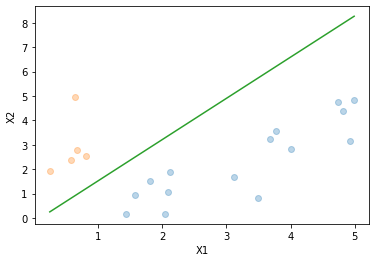

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin

class Perceptron(BaseEstimator, ClassifierMixin):
    """
    Versão Adaline do Perceptron com limite de iterações,
    treinado em batch, com bias e taxa de aprendizado.
    """
    def __init__(self, training_algorithm=DescidaGradiente()):
        self.w = None
        self.activation = sign
        self.training_algorithm = training_algorithm
    
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb

    def fit(self, X, y):
        Xb = Perceptron.includebias(X)
        self.w = self.training_algorithm.getW(Xb, y)
    
    def __pre_activation(self, X):
        Xb = Perceptron.includebias(X)
        return np.matmul(Xb, self.w)

    def predict(self, X):
        a = self.__pre_activation(X)
        ypred = self.activation(a)
        return ypred

perceptron = Perceptron(training_algorithm=DescidaGradiente(cost=LogLikelihood()))
perceptron.fit(Xtr, ytr)
print(accuracy(ytr, perceptron.predict(Xtr)))
print(perceptron.w)
plotaHiperplanoDatasetBidimensional(Xtr, ytr, perceptron.w[1:], perceptron.w[0])
print(sum(perceptron.w**2))


In [9]:
Xte, yte = criaDatasetBidimensionalBinárioInclinado(n=1000, slop=slop, intercept=intercept)

1.0 0.938 [-0.00988077  0.53918155 -0.35544173]


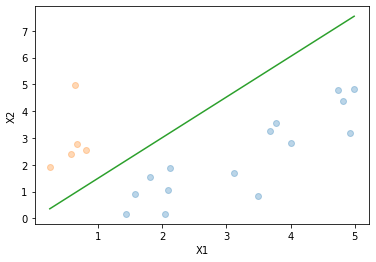

1.0 0.889 [ 0.10054947  0.31872084 -0.14597563]


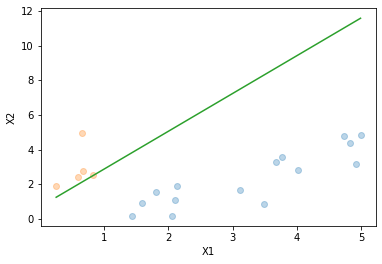

1.0 0.967 [-0.27414994  1.31247885 -0.71638327]


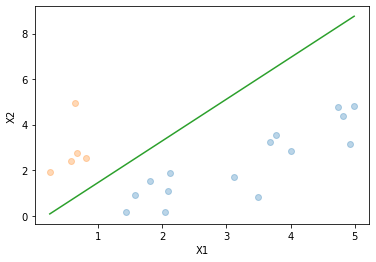

1.0 0.943 [ 0.21055292  4.21804824 -2.80082175]


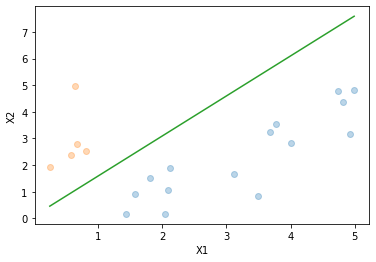

In [10]:
custos = [WidrowHoff(), SmoothedSurrogate(), HingeLoss(), LogLikelihood()]

for custo in custos:
    perceptron = Perceptron(training_algorithm=DescidaGradiente(regularization=0, cost=custo))
    perceptron.fit(Xtr, ytr)
    print(accuracy(ytr, perceptron.predict(Xtr)), accuracy(yte, perceptron.predict(Xte)), perceptron.w)
    plotaHiperplanoDatasetBidimensional(Xtr, ytr, perceptron.w[1:], perceptron.w[0])
    plt.show()
